In [27]:
from dotenv import load_dotenv 
import os 
from langchain_groq import ChatGroq
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

model = ChatGroq(model="llama-3.3-70b-versatile")
result = model.invoke("Hello")
result

AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.02288466, 'prompt_time': 0.00171455, 'queue_time': 0.015350534, 'total_time': 0.02459921}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9a8b91ba77', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--58ced832-3d4d-433d-9592-4ca5db85b4e5-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [28]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

In [29]:
from pydantic import BaseModel , Field
from typing_extensions import Literal , TypedDict
from langchain_core.messages import HumanMessage , SystemMessage

class Section(BaseModel):
    title : str = Field(description="Title for this section of the report based on the text")
    desc : str = Field(description="Brief overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections : list[Section] = Field(description="Sections of the report")

planner = model.with_structured_output(Sections)

In [30]:
sections = planner.invoke("Agentic Ai")

In [31]:
sections

Sections(sections=[Section(title='Introduction to Agentic AI', desc='Agentic AI is a type of artificial intelligence that enables machines to make decisions and act autonomously, based on their own goals and motivations.'), Section(title='Key Characteristics of Agentic AI', desc='Agentic AI systems are typically characterized by their ability to perceive their environment, reason about their goals and motivations, and take actions to achieve them.'), Section(title='Applications of Agentic AI', desc='Agentic AI has a wide range of potential applications, including robotics, autonomous vehicles, and smart homes.')])

In [32]:
from langgraph.constants import Send
class State(TypedDict):
    title : str
    sections : list[Section]
    completed_sections : Annotated[list , operator.add]
    final_report : str

class WorkerState(TypedDict):
    section : Section 
    completed_sections : Annotated[list, operator.add]

In [33]:
def orchestrator(state : State):
    """Orchestrator that generates the plan of the report"""

    sections = planner.invoke([
        SystemMessage(content="Generate sections plan of report based on the topic"),
        HumanMessage(content=f"Here is the report Topic : {state['title']}")
    ])
    return {"sections" : sections.sections}

def llm_call(state : WorkerState):
    """Worker write the section of report"""
    section = model.invoke([
        SystemMessage(content="Write a report section following the provided name and description.  Write the report in professional researcher style. Include no preamble for each section. Use markdown formatting."),
        HumanMessage(content=(f"Here is the section name: {state['section'].title} and description: {state['section'].desc}"))
    ])
    return {"completed_sections" : [section.content]}


def assign_worker(state : State):
    """Assign LLM to each section of the report"""
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}
    

## `Defining The Graph`

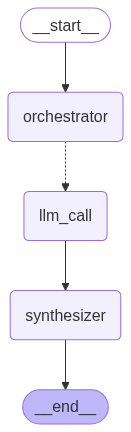

In [34]:
# Build workflow


from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_worker, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [35]:
state = orchestrator_worker.invoke({"title": "Create a report on Computer Vision"})

from IPython.display import Markdown
Markdown(state["final_report"])

### Introduction to Computer Vision
Computer vision is a field of artificial intelligence that enables computers to interpret and understand visual information from the world. It involves the development of algorithms and statistical models that allow computers to process, analyze, and comprehend digital images and videos. The goal of computer vision is to replicate the human visual system, enabling computers to perceive, process, and respond to visual data in a manner similar to humans.

#### History of Computer Vision
The history of computer vision dates back to the 1960s, when the first computer vision systems were developed. These early systems were primarily focused on image processing and object recognition. In the 1970s and 1980s, computer vision research expanded to include topics such as edge detection, feature extraction, and object recognition. The 1990s saw the introduction of machine learning techniques, including neural networks, which significantly improved the accuracy and robustness of computer vision systems. Today, computer vision is a rapidly evolving field, with applications in areas such as robotics, healthcare, security, and autonomous vehicles.

#### Applications of Computer Vision
Computer vision has numerous applications across various industries, including:
* **Image and Video Analysis**: Computer vision is used in image and video analysis for applications such as object detection, facial recognition, and sentiment analysis.
* **Robotics and Autonomous Systems**: Computer vision is used in robotics and autonomous systems to enable robots and vehicles to perceive and respond to their environment.
* **Healthcare**: Computer vision is used in healthcare for medical image analysis, disease diagnosis, and patient monitoring.
* **Security and Surveillance**: Computer vision is used in security and surveillance systems to detect and recognize individuals, track objects, and monitor activity.
* **Autonomous Vehicles**: Computer vision is used in autonomous vehicles to enable vehicles to perceive and respond to their environment, including detecting pedestrians, lanes, and obstacles.

---

### Fundamentals of Computer Vision
#### Introduction to Image Formation
Image formation is the process by which a 2D representation of a 3D scene is created. This is achieved through the use of cameras, which capture light reflected from objects in the scene. The resulting image is a projection of the 3D world onto a 2D plane, with the camera's sensor recording the intensity and color of the light at each point. Understanding image formation is crucial in computer vision, as it provides the foundation for subsequent processing and analysis.

#### Feature Detection
Feature detection is the process of identifying and extracting meaningful features from an image. These features can include edges, corners, lines, and shapes, which are used to describe the content of the image. Common feature detection algorithms include the Canny edge detector, the Harris corner detector, and the SIFT (Scale-Invariant Feature Transform) algorithm. Feature detection is a critical step in many computer vision applications, including object recognition, tracking, and scene understanding.

#### Object Recognition
Object recognition is the process of identifying and classifying objects within an image or scene. This involves using features extracted from the image to match against a database of known objects or to learn the patterns and characteristics of objects through machine learning algorithms. Object recognition is a fundamental problem in computer vision, with applications in areas such as robotics, surveillance, and autonomous vehicles. Techniques used in object recognition include template matching, feature-based recognition, and deep learning-based approaches such as convolutional neural networks (CNNs).

#### Key Challenges and Limitations
Despite significant advances in computer vision, there are still several key challenges and limitations to be addressed. These include:
* **Variability in lighting and viewpoint**: Changes in lighting and viewpoint can significantly affect the appearance of objects, making recognition more difficult.
* **Occlusion and clutter**: Objects may be partially or fully occluded by other objects, or may be surrounded by clutter, which can make recognition more challenging.
* **Intra-class variation**: Objects within the same class can exhibit significant variation in appearance, making recognition more difficult.
* **Scalability and efficiency**: Computer vision algorithms must be able to process large amounts of data efficiently, while also scaling to meet the needs of real-time applications.

---

### Computer Vision Techniques
#### Introduction to Image Processing
Image processing is a fundamental technique in computer vision, involving the manipulation and analysis of digital images to extract relevant information. This process typically begins with image acquisition, where images are obtained from various sources such as cameras, scanners, or other sensing devices. Subsequent steps include image preprocessing, which may involve operations like noise reduction, contrast enhancement, and image normalization to improve image quality and facilitate further analysis.

#### Image Segmentation
Image segmentation is a critical computer vision technique used to partition an image into its constituent parts or objects of interest. This process enables the separation of objects from the background and the identification of distinct regions within the image. Common image segmentation techniques include thresholding, edge detection, and region growing. Thresholding involves separating pixels based on their intensity values, while edge detection identifies boundaries between objects by detecting abrupt changes in intensity. Region growing, on the other hand, involves merging pixels or regions based on similarity criteria such as color or texture.

#### Object Tracking
Object tracking is another essential computer vision technique that involves monitoring the movement of objects across a sequence of images or video frames. This technique has numerous applications, including surveillance, robotics, and autonomous vehicles. Object tracking algorithms can be broadly categorized into two types: offline and online tracking. Offline tracking involves processing the entire video sequence at once, allowing for more complex computations but requiring the entire dataset to be available beforehand. Online tracking, in contrast, processes frames in real-time, making it more suitable for applications requiring immediate feedback.

#### Feature Extraction and Description
Feature extraction and description are crucial steps in computer vision that enable the representation of images or objects in a compact and meaningful form. Features can be based on various attributes such as color, texture, shape, or motion. Common feature descriptors include Scale-Invariant Feature Transform (SIFT), Speeded Up Robust Features (SURF), and Histogram of Oriented Gradients (HOG). These descriptors are designed to capture distinctive characteristics of objects or scenes, facilitating tasks such as object recognition, image matching, and content-based image retrieval.

#### Deep Learning in Computer Vision
The advent of deep learning has revolutionized the field of computer vision, offering unparalleled performance in a wide range of tasks including image classification, object detection, segmentation, and generation. Convolutional Neural Networks (CNNs), in particular, have become a cornerstone of computer vision, leveraging convolutional and pooling layers to extract hierarchical features from images. Other deep learning architectures such as Recurrent Neural Networks (RNNs) and Generative Adversarial Networks (GANs) have also found applications in computer vision, especially in areas like video analysis and image synthesis. The integration of deep learning with traditional computer vision techniques has opened up new avenues for research and development, promising to solve complex visual perception tasks with greater accuracy and efficiency.

---

### Deep Learning in Computer Vision
Deep learning has revolutionized the field of computer vision, enabling state-of-the-art performance in various tasks such as image classification, object detection, segmentation, and generation. The key to this success lies in the ability of deep neural networks to learn complex, abstract representations of visual data.

#### Deep Learning Architectures
Several deep learning architectures have been proposed for computer vision tasks, including:
* **Convolutional Neural Networks (CNNs)**: CNNs are the most widely used architecture for computer vision tasks, leveraging convolutional and pooling layers to extract features from images.
* **Recurrent Neural Networks (RNNs)**: RNNs are used for tasks that involve sequential data, such as image captioning or video analysis.
* **Generative Adversarial Networks (GANs)**: GANs consist of a generator and a discriminator, and are used for image generation, style transfer, and data augmentation.

#### Applications of Deep Learning in Computer Vision
Deep learning has numerous applications in computer vision, including:
* **Image Classification**: Deep learning models have achieved state-of-the-art performance in image classification tasks, such as object recognition and scene understanding.
* **Object Detection**: Deep learning-based object detection algorithms, such as YOLO and SSD, have improved the accuracy and efficiency of object detection tasks.
* **Image Segmentation**: Deep learning models have been used for image segmentation tasks, such as semantic segmentation and instance segmentation.
* **Image Generation**: Deep learning models, such as GANs and VAEs, have been used for image generation, style transfer, and data augmentation.

#### Challenges and Future Directions
Despite the significant progress made in deep learning for computer vision, there are still several challenges and future directions to be explored, including:
* **Explainability and Interpretability**: Deep learning models are often difficult to interpret, making it challenging to understand their decision-making processes.
* **Adversarial Robustness**: Deep learning models are vulnerable to adversarial attacks, which can compromise their performance and security.
* **Domain Adaptation**: Deep learning models often require large amounts of labeled data, which can be challenging to obtain in certain domains or applications.

---

### Applications of Computer Vision
Computer vision has numerous real-world applications that are transforming various industries. 
#### Surveillance
The use of computer vision in surveillance systems enables the detection and recognition of objects, people, and activities, enhancing security and public safety. 
* Facial recognition technology is employed to identify individuals in crowds, aiding law enforcement agencies in crime prevention and investigation.
* Object detection algorithms are used to monitor and track suspicious activities, such as intrusions or thefts.
* Automated number plate recognition systems are used to track vehicle movements and enforce traffic regulations.

#### Healthcare
Computer vision is being increasingly used in healthcare to improve patient outcomes and streamline clinical workflows.
* Medical image analysis is used to diagnose diseases, such as cancer, from images like X-rays, CT scans, and MRIs.
* Computer vision-powered systems are used to track patient vital signs, monitor medication adherence, and detect falls.
* Surgical robotics and navigation systems rely on computer vision to provide real-time feedback and guidance during surgical procedures.

#### Autonomous Vehicles
Computer vision plays a critical role in the development of autonomous vehicles, enabling them to perceive and respond to their environment.
* Object detection and tracking algorithms are used to identify pedestrians, vehicles, and other obstacles on the road.
* Lane detection and tracking systems help autonomous vehicles stay within their lane and navigate through intersections.
* Scene understanding and segmentation algorithms enable autonomous vehicles to comprehend complex scenarios, such as construction zones or school zones, and adjust their behavior accordingly.

These applications demonstrate the significant impact of computer vision on various aspects of our lives, from enhancing public safety to improving healthcare outcomes and transforming the transportation industry. As computer vision technology continues to evolve, we can expect to see even more innovative applications in the future.

---

### Challenges and Future Directions
The field of computer vision has made significant progress in recent years, with advancements in deep learning techniques and the increasing availability of large datasets. However, several challenges remain to be addressed. 
#### Current Challenges
* **Data Quality and Availability**: One of the major challenges in computer vision is the need for high-quality, diverse, and large-scale datasets. Many existing datasets are biased towards specific domains or scenarios, which can result in models that do not generalize well to new environments.
* **Explainability and Interpretability**: As computer vision models become more complex, it is essential to develop techniques that provide insights into their decision-making processes. This is critical for applications where model interpretability is crucial, such as in healthcare or autonomous vehicles.
* **Real-World Variability**: Computer vision models often struggle to generalize to real-world scenarios, where lighting conditions, occlusions, and other factors can significantly impact performance. Developing models that can adapt to these variations is an active area of research.
#### Future Developments
* **Multimodal Learning**: Future research is expected to focus on multimodal learning, where computer vision is integrated with other modalities, such as natural language processing or audio processing. This can enable more comprehensive understanding of complex scenes and events.
* **Edge AI and Efficient Models**: As computer vision applications become more ubiquitous, there is a growing need for efficient models that can run on edge devices, such as smartphones or smart home devices. This requires developing models that are optimized for low computational resources and power consumption.
* **Adversarial Robustness**: As computer vision models are deployed in increasingly critical applications, ensuring their robustness to adversarial attacks is essential. Future research will focus on developing models that can detect and defend against such attacks, ensuring the reliability and security of computer vision systems.